# Distance Based Probability Sampling

The main idea of this sampling method is to assign a higher/lower value of sampling a distant point. 

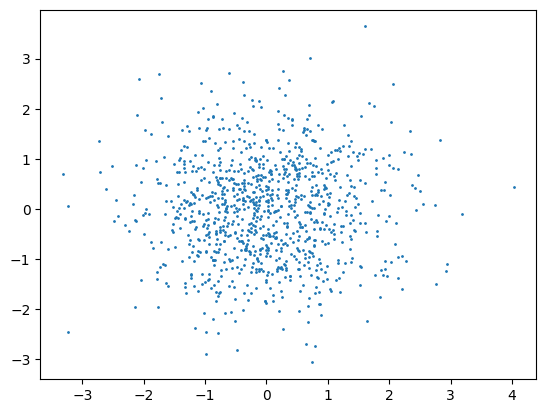

In [1]:
import numpy as np
import matplotlib.pyplot as plt

num_pts = 1000
rand_pts = np.random.randn(2, num_pts)

plt.scatter(rand_pts[0], rand_pts[1], s=1)

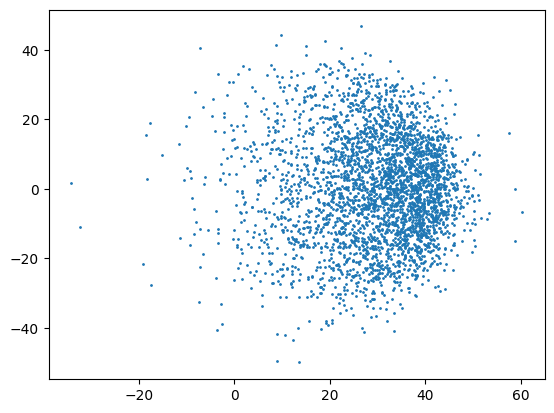

In [37]:
num_pts = 10000
rand_pts = np.random.randn(2, num_pts)
rand_pts[0] *= 20
rand_pts[0] += 50
rand_pts[1] *= 20
sampling_prob = (np.linalg.norm(rand_pts, axis=0))**-20
sampling_prob /= np.sum(sampling_prob).astype(float)
pts_subsampled = rand_pts[:,np.random.choice(np.arange(rand_pts.shape[1]), int(rand_pts.shape[1]/3), replace=False, p=sampling_prob)]
plt.scatter(pts_subsampled[0], pts_subsampled[1], s=1)

In [3]:
import torch 

def range_dependent_subsample(
    pts: np.ndarray, factor: float = 5.0, num_pts: int = 1000
):
    assert num_pts <= pts.shape[1]
    sampling_prob = (np.linalg.norm(pts, axis=0)) ** -factor
    sampling_prob /= np.sum(sampling_prob).astype(float)
    return pts[
        :,
        np.random.choice(
            np.arange(pts.shape[1]),
            num_pts,
            replace=False,
            p=sampling_prob,
        ),
    ]

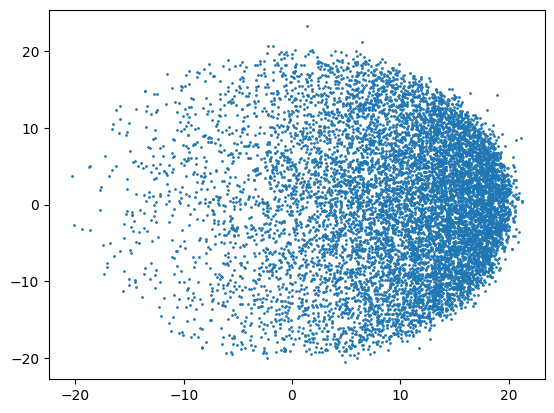

In [9]:
num_pts = 300000
rand_pts = np.random.randn(2, num_pts)
rand_pts[0] *= 20
rand_pts[0] += 50
rand_pts[1] *= 20
pts_subsampled = range_dependent_subsample(rand_pts, factor=50, num_pts=10000)
plt.scatter(pts_subsampled[0], pts_subsampled[1], s=1)

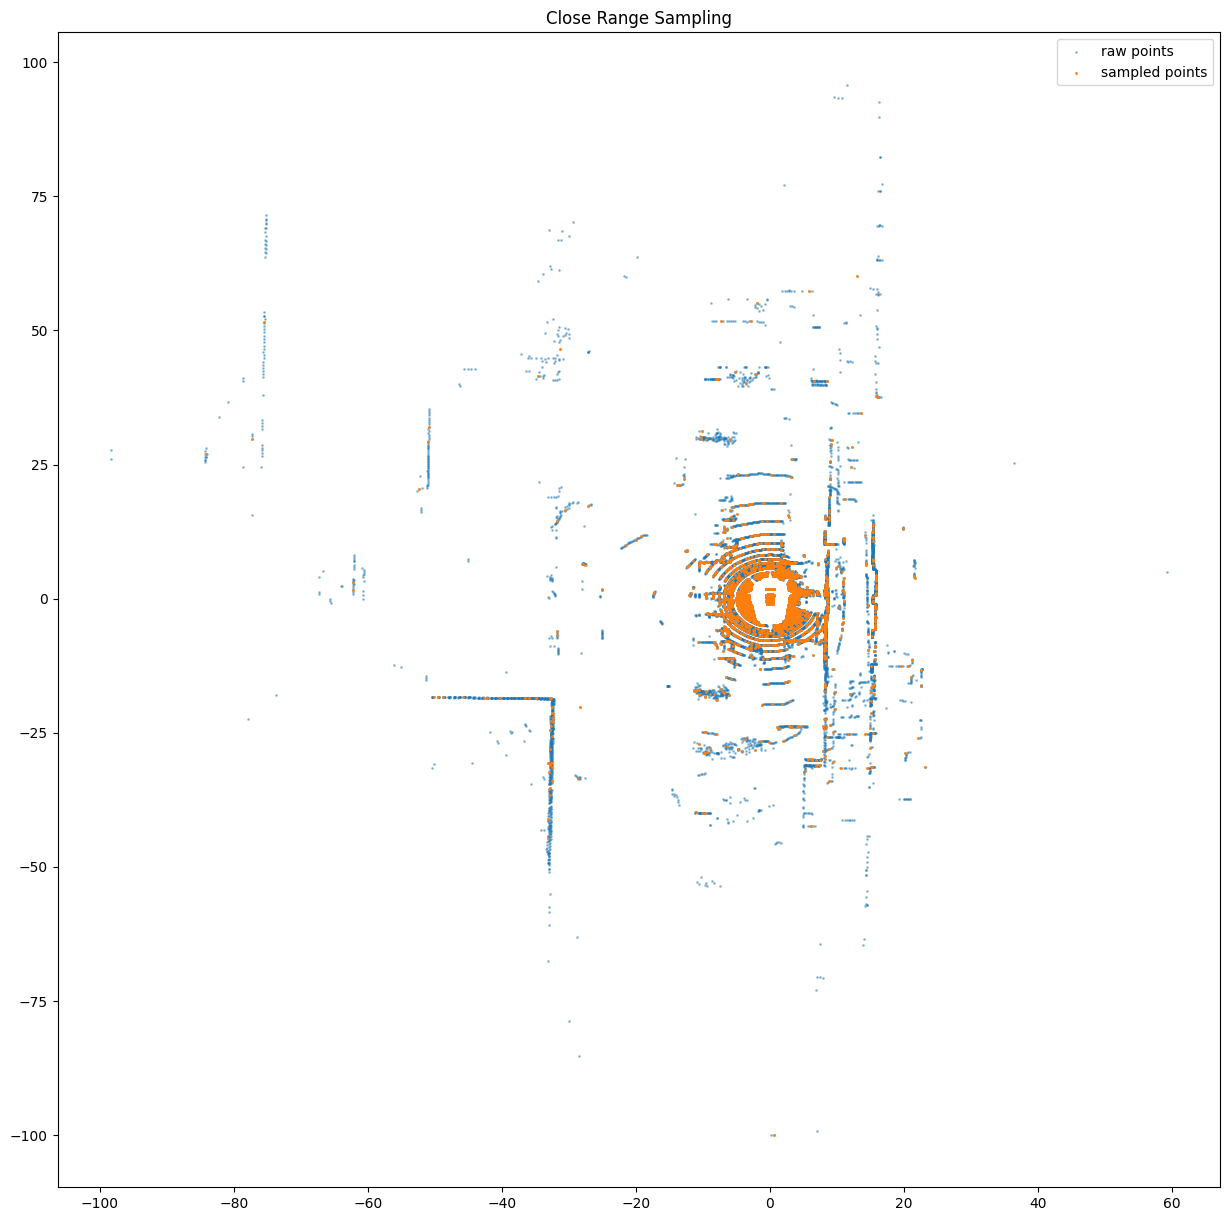

In [7]:
pcd = np.fromfile('../../mmdetection3d/data/nuscenes/samples/LIDAR_TOP/n008-2018-05-21-11-06-59-0400__LIDAR_TOP__1526915243047392.pcd.bin', dtype=np.float32).reshape(-1,5).T
pcd_subsampled = range_dependent_subsample(pcd, factor=1, num_pts=5000)
plt.figure(figsize=(15,15))
plt.title('Close Range Sampling')
plt.scatter(pcd[0], pcd[1], s=1, alpha=0.4)
plt.scatter(pcd_subsampled[0], pcd_subsampled[1], s=1)
plt.legend(['raw points', 'sampled points'])

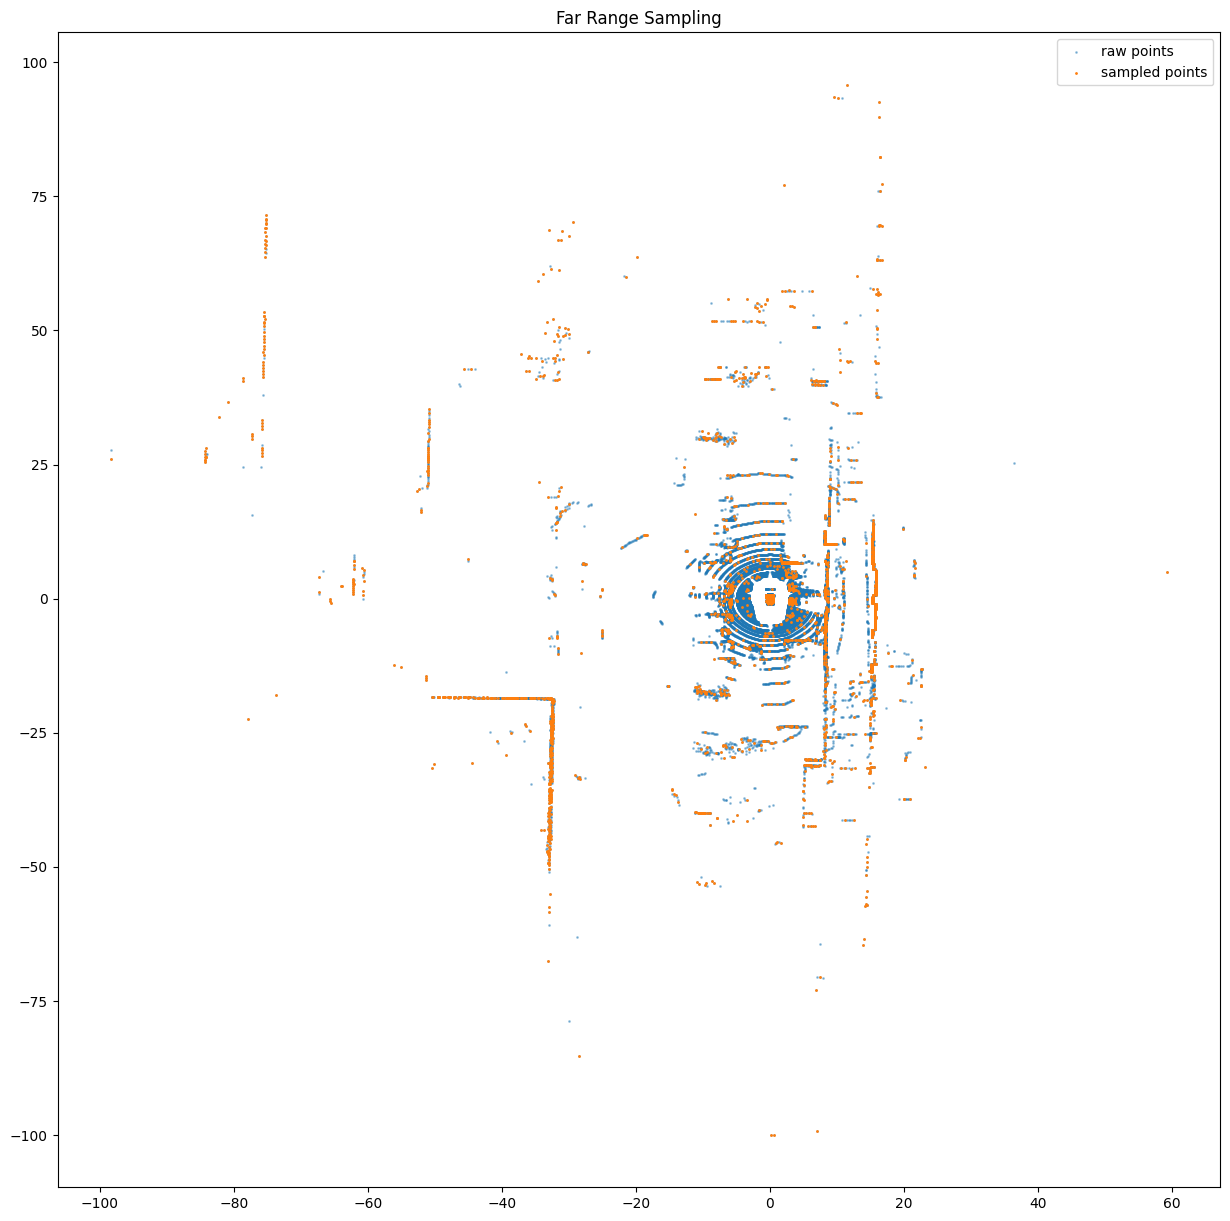

In [75]:
pcd_subsampled = range_dependent_subsample(pcd, factor=-2.0, num_pts=5000)
plt.figure(figsize=(15, 15))
plt.title("Far Range Sampling")
plt.scatter(pcd[0], pcd[1], s=1, alpha=0.4)
plt.scatter(pcd_subsampled[0], pcd_subsampled[1], s=1)
plt.legend(['raw points', 'sampled points'])

In [33]:
def torch_range_dependent_subsample(
    pts: torch.Tensor, factor: float = 5.0, num_pts: int = 1000, pcd_range
):
    assert num_pts <= pts.shape[1]
    sampling_prob = (torch.norm(pts, dim=0)) ** -factor
    sampling_prob /= torch.sum(sampling_prob).float()
    idx = sampling_prob.multinomial(num_pts)
    return pts[:, idx]

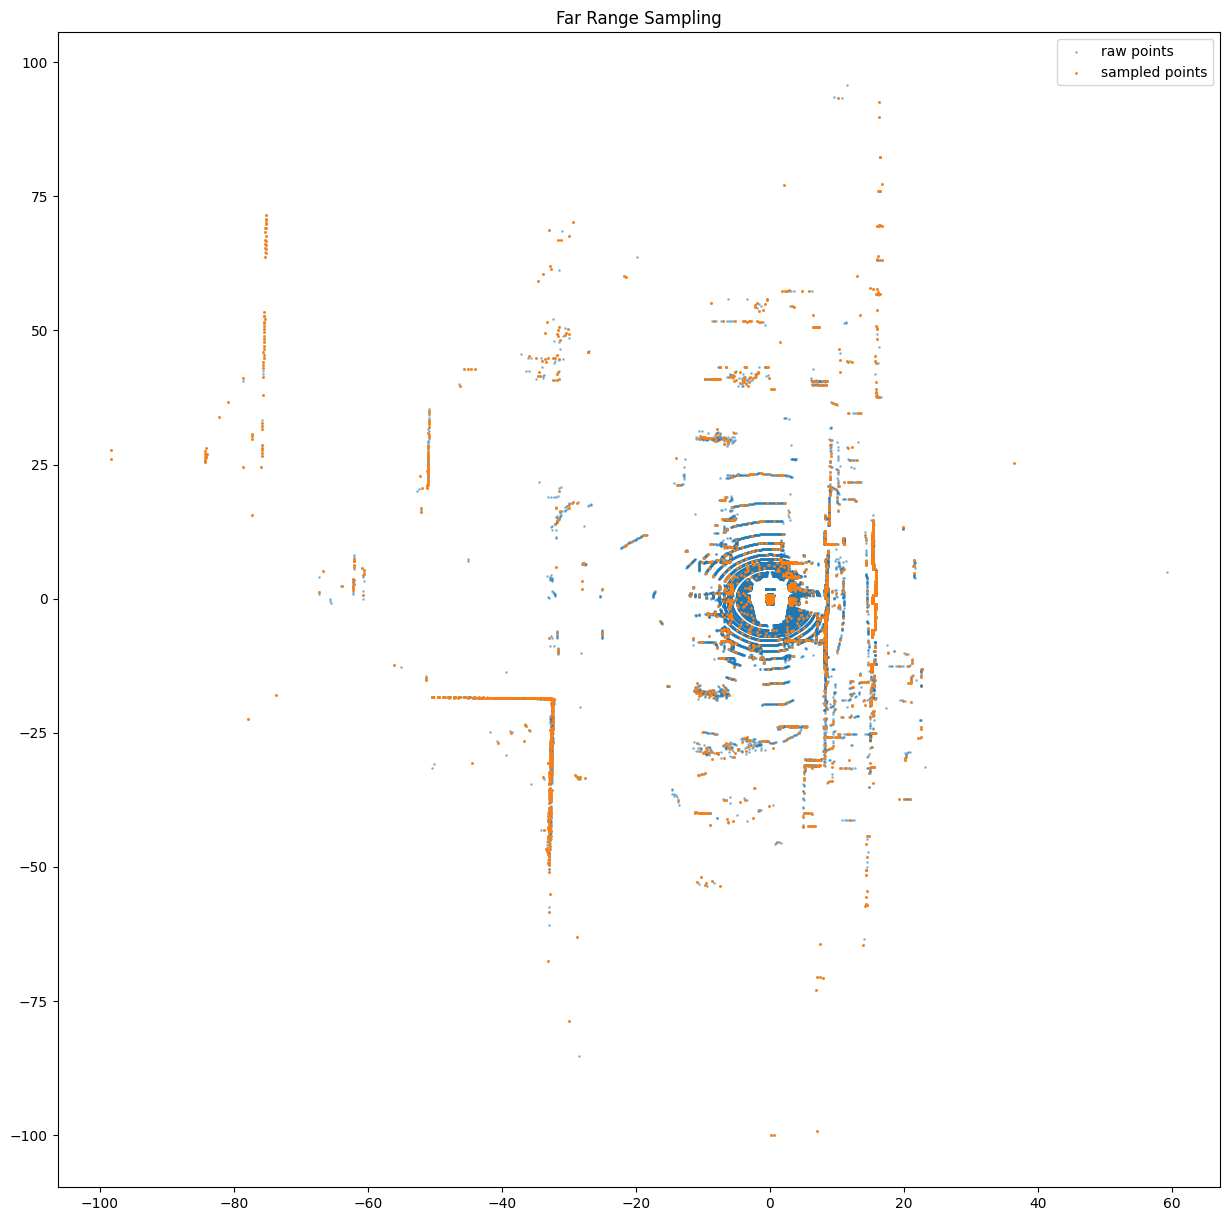

In [80]:
pcd_subsampled_torch = torch_range_dependent_subsample(torch.from_numpy(pcd), factor=-2.0, num_pts=5000)
plt.figure(figsize=(15, 15))
plt.title("Far Range Sampling")
plt.scatter(pcd[0], pcd[1], s=1, alpha=0.4)
plt.scatter(pcd_subsampled_torch[0], pcd_subsampled_torch[1], s=1)
plt.legend(['raw points', 'sampled points'])

In [36]:
print(max(pcd_subsampled[1,:]), max(pcd_subsampled_torch[1,:]), max(pcd[1,:]))

tensor(95.7890) tensor(95.7890) 95.78897


In [81]:
def donut_cropbox(
     pts: torch.Tensor,
     point_cloud_range: [-50.0, -54.0, -5.0, 50.0, 54.0, 3.0]):
     pcd_range = np.array(point_cloud_range, dtype=np.float32)
     # do inverse crop where the points within the range are discarded and points outside are kept
     mask = (pts[0] < pcd_range[0]) | (pts[0] > pcd_range[3]) | (pts[1] < pcd_range[1]) | (pts[1] > pcd_range[4]) | (pts[2] < pcd_range[2]) | (pts[2] > pcd_range[5])
     print(mask.shape)
     return pts[:, mask]


(34720,)


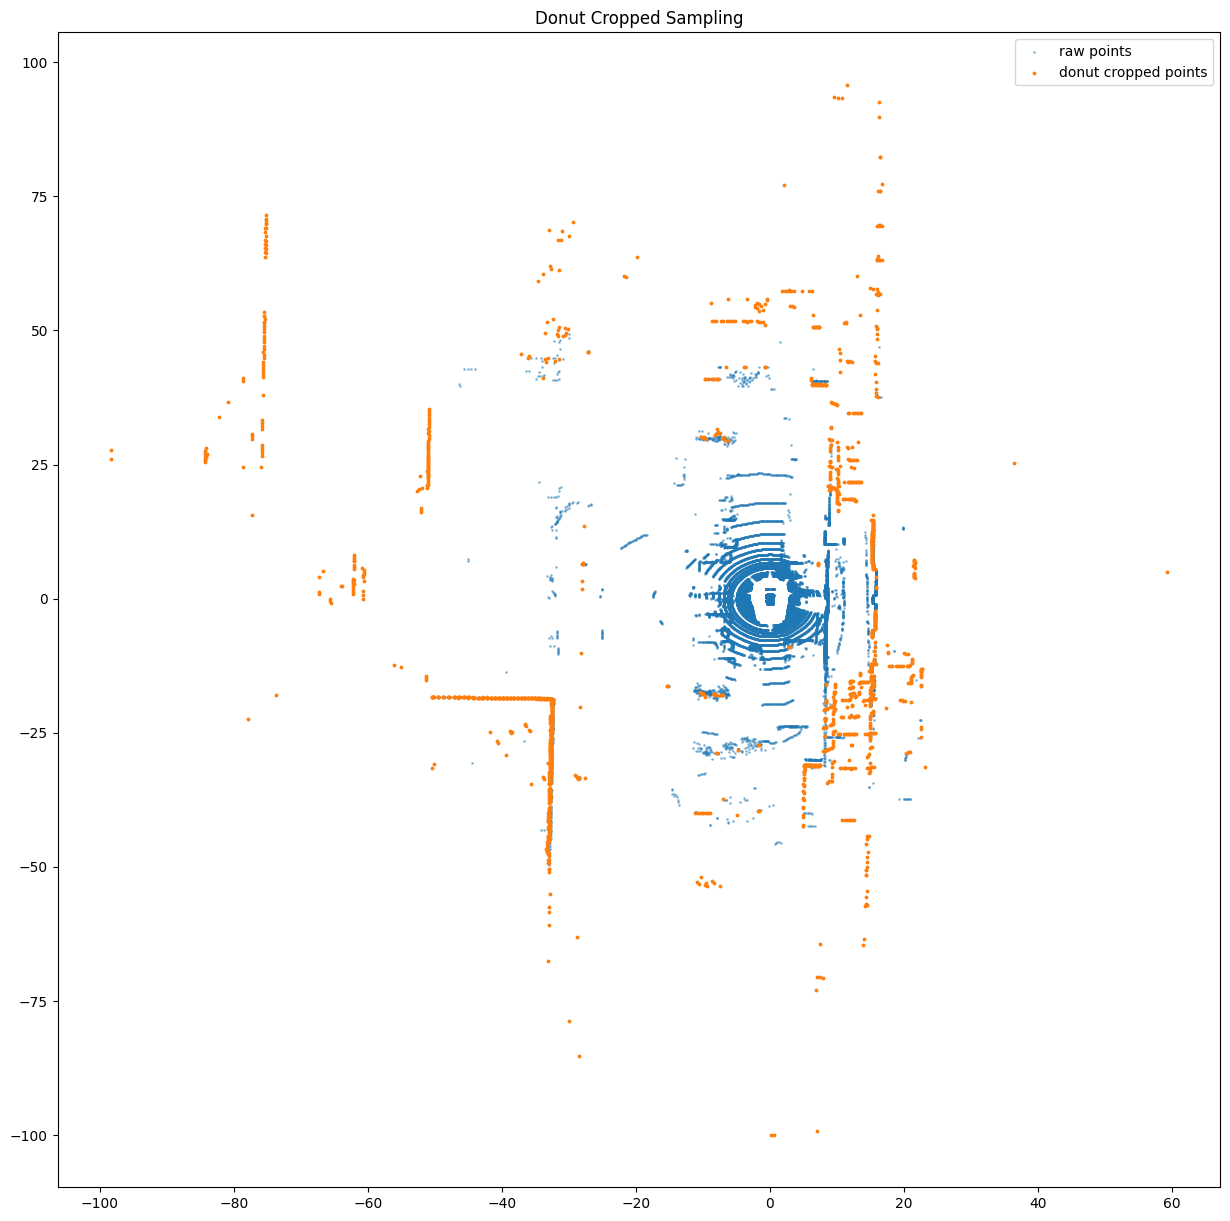

In [82]:
donut_cropped = donut_cropbox(pcd, point_cloud_range=[-50.0, -50.0, -5.0, 50.0, 50.0, 3.0])
plt.figure(figsize=(15, 15))
plt.title("Donut Cropped Sampling")
plt.scatter(pcd[0], pcd[1], s=1, alpha=0.4)
plt.scatter(donut_cropped[0], donut_cropped[1], s=3)
plt.legend(['raw points', 'donut cropped points'])